## Regression: Hyundai Heavy Industry Cruise ship data
http://www.hyundai.eu

** Dataset Information: **

Measurements of ship size, capacity, crew, and age for 158 cruise ships

** Attribute Information: **

- Ship Name     1-20
- Cruise Line   21-40
- Age (as of 2013)   46-48
- Tonnage (1000s of tons)   50-56
- passengers (100s)   58-64
- Length (100s of feet)  66-72
- Cabins  (100s)   74-80
- Passenger Density   82-88
- Crew  (100s)   90-96

** Objective of this project **

predict how many crew members will be needed for future ships

## Data

In [1]:
import findspark
findspark.init('/home/danny/spark-2.2.1-bin-hadoop2.7')

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('cruise').getOrCreate()

In [2]:
# Load Data
df = spark.read.csv('cruise_ship_info.csv',inferSchema=True,header=True)
# Inspect Data
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [3]:
df = df.withColumnRenamed('crew','label')
df.show(5)

+-----------+-----------+---+------------------+----------+------+------+-----------------+-----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|label|
+-----------+-----------+---+------------------+----------+------+------+-----------------+-----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64| 3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64| 3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8|  6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99| 19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36| 10.0|
+-----------+-----------+---+------------------+----------+------+------+-----------------+-----+
only showing top 5 rows



In [4]:
df.head()

Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, label=3.55)

In [5]:
df.describe().show()

+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|summary|Ship_name|Cruise_line|               Age|           Tonnage|       passengers|           length|            cabins|passenger_density|            label|
+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|  count|      158|        158|               158|               158|              158|              158|               158|              158|              158|
|   mean| Infinity|       null|15.689873417721518| 71.28467088607599|18.45740506329114|8.130632911392404| 8.830000000000005|39.90094936708861|7.794177215189873|
| stddev|      NaN|       null| 7.615691058751413|37.229540025907866|9.677094775143416|1.793473548054825|4.4714172221480615| 8.63921711391542|3.503486564627034|
|    min|Adventure|    Azamara|   

In [6]:
from pyspark.sql.functions import corr
df.select(corr('label','passengers')).show()
df.select(corr('label','cabins')).show()

+-----------------------+
|corr(label, passengers)|
+-----------------------+
|     0.9152341306065384|
+-----------------------+

+-------------------+
|corr(label, cabins)|
+-------------------+
| 0.9508226063578497|
+-------------------+



## Data preprocessing

In [7]:
from pyspark.ml.feature import StringIndexer,VectorAssembler

** Convert categorical to numeric **

In [8]:
df.groupBy('Cruise_line').count().show()

+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|            Costa|   11|
|              P&O|    6|
|           Cunard|    3|
|Regent_Seven_Seas|    5|
|              MSC|    8|
|         Carnival|   22|
|          Crystal|    2|
|           Orient|    1|
|         Princess|   17|
|        Silversea|    4|
|         Seabourn|    3|
| Holland_American|   14|
|         Windstar|    3|
|           Disney|    2|
|        Norwegian|   13|
|          Oceania|    3|
|          Azamara|    2|
|        Celebrity|   10|
|             Star|    6|
|  Royal_Caribbean|   23|
+-----------------+-----+



In [9]:
indexer = StringIndexer(inputCol="Cruise_line", outputCol="cruise_cat")
indexed = indexer.fit(df).transform(df)
indexed.select('cruise_cat').show(5)

+----------+
|cruise_cat|
+----------+
|      16.0|
|      16.0|
|       1.0|
|       1.0|
|       1.0|
+----------+
only showing top 5 rows



** Split Features & Class (or target) **

In [10]:
indexed.columns

['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'label',
 'cruise_cat']

In [11]:
# combine features into a single column
assembler = VectorAssembler(inputCols=['Age','Tonnage','passengers',
                                       'length','cabins','passenger_density',
                                        'cruise_cat'],
                            outputCol='features') 
final_data = assembler.transform(indexed).select('features','label')
final_data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[6.0,30.276999999...| 3.55|
|[6.0,30.276999999...| 3.55|
|[26.0,47.262,14.8...|  6.7|
|[11.0,110.0,29.74...| 19.1|
|[17.0,101.353,26....| 10.0|
+--------------------+-----+
only showing top 5 rows



** Split Train Test sets **

In [12]:
seed = 101 #for reproducibility
train_data,test_data = final_data.randomSplit([0.7,0.3],seed=seed)
train_data.describe().show()
test_data.describe().show()

+-------+-----------------+
|summary|            label|
+-------+-----------------+
|  count|              116|
|   mean|7.761982758620701|
| stddev| 3.46703186422136|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|                42|
|   mean| 7.883095238095238|
| stddev|3.6435566168205447|
|    min|              1.46|
|    max|              19.1|
+-------+------------------+



## Baseline Model

In [13]:
from pyspark.ml.regression import (LinearRegression,GBTRegressor,
                                   DecisionTreeRegressor,RandomForestRegressor)
from pyspark.ml.evaluation import RegressionEvaluator

#### Train Models

In [14]:
# Initialize multiple regressors
lrr = LinearRegression()
dtr = DecisionTreeRegressor(seed=seed)
rfr = RandomForestRegressor(seed=seed)
gbr = GBTRegressor(seed=seed)

# Train the models 
lr_model = lrr.fit(train_data)
dtr_model = dtr.fit(train_data)
rfr_model = rfr.fit(train_data)
gbr_model = gbr.fit(train_data)

#### Evaluate Models

In [15]:
# Make predictions
lr_predictions = lr_model.transform(test_data)
dtr_predictions = dtr_model.transform(test_data)
rfr_predictions = rfr_model.transform(test_data)
gbr_predictions = gbr_model.transform(test_data)

# Evaluate the models
mse_eval = RegressionEvaluator(metricName='mse')
r2_eval = RegressionEvaluator(metricName='r2')
print('\t\t\tMSE\tR2')
print('Linear Regression:\t{:.3f}\t{:.3f}'.format(mse_eval.evaluate(lr_predictions),
                                          r2_eval.evaluate(lr_predictions)))
print('Decision Tree:\t\t{:.3f}\t{:.3f}'.format(mse_eval.evaluate(dtr_predictions),
                                          r2_eval.evaluate(dtr_predictions)))
print('Random Forest:\t\t{:.3f}\t{:.3f}'.format(mse_eval.evaluate(rfr_predictions),
                                          r2_eval.evaluate(rfr_predictions)))
print('GBT:\t\t\t{:.3f}\t{:.3f}'.format(mse_eval.evaluate(gbr_predictions),
                                          r2_eval.evaluate(gbr_predictions)))

			MSE	R2
Linear Regression:	2.295	0.823
Decision Tree:		2.504	0.807
Random Forest:		2.395	0.815
GBT:			2.437	0.812


## Parameter tuning

#### Grid Search

In [16]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# randomforest
regressor = LinearRegression()
# grid params
paramGrid = ParamGridBuilder() \
    .addGrid(regressor.regParam, [0.0, 0.2, 0.4]) \
    .addGrid(regressor.elasticNetParam, [0.0, 0.5 ,1.0]) \
    .build()
# cross validation
crossval = CrossValidator(estimator=regressor,
                          estimatorParamMaps=paramGrid,
                          evaluator=mse_eval,
                          numFolds=3,
                          seed=seed)
cvModel = crossval.fit(train_data)
# results
print(cvModel.avgMetrics)
print(cvModel.bestModel) #regParam=0, elasticNetParam=0

[0.5250554892757787, 0.6526646129733067, 0.6932388950526308, 0.5250554892757787, 0.6391708975720989, 0.7063801081544242, 0.5250554892757787, 0.6734028637065406, 0.7942789618625546]
LinearRegression_4a7c879e96a9e924a00f


#### Evaluate the best model

In [17]:
# make predictions
predictions = cvModel.transform(test_data)
# calculate mse, r2 score
print('\t\t\tMSE\tR2')
print('Linear Regression:\t{:.3f}\t{:.3f}'.format(mse_eval.evaluate(predictions),
                                          r2_eval.evaluate(predictions)))

			MSE	R2
Linear Regression:	2.295	0.823


## Final Model

In [18]:
# Train the model
regressor = LinearRegression(regParam=0.0, elasticNetParam=0.0)
final_model = regressor.fit(train_data)
# Evaluate the model
test_results = final_model.evaluate(test_data)
print('RMSE:\t{:.3f}'.format(test_results.rootMeanSquaredError))
print('MSE:\t{:.3f}'.format(test_results.meanSquaredError))
print('R2:\t{:.3f}'.format(test_results.r2))

RMSE:	1.515
MSE:	2.295
R2:	0.823


+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[6.0,30.276999999...| 3.55| 4.328294690718178|
|[6.0,90.0,20.0,9....|  9.0|10.090913020441276|
|[6.0,93.0,23.94,9...|11.09|10.361966767736325|
|[6.0,113.0,37.82,...| 12.0|11.438695124752334|
|[7.0,158.0,43.7,1...| 13.6|13.800265094541881|
+--------------------+-----+------------------+
only showing top 5 rows



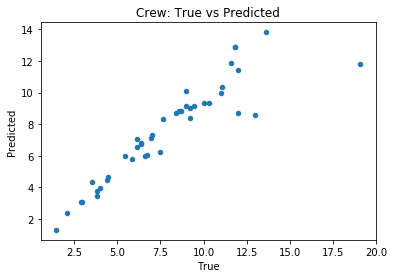

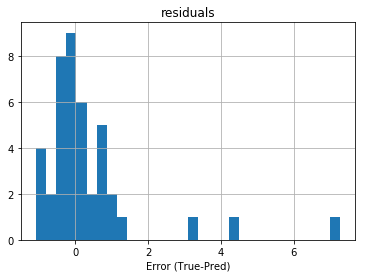

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# make predictions
predictions = final_model.transform(test_data)
predictions.show(5)
# visualize the results
df_pred = predictions.toPandas()
df_pred.plot.scatter(x='label',y='prediction')
plt.title('Crew: True vs Predicted')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()
# residuals
test_results.residuals.toPandas().hist(bins=30)
plt.xlabel('Error (True-Pred)')
plt.show()

In [20]:
spark.stop()